In [1]:
# Packages
using JuMP
using HiGHS
using CSV
using DataFrames
using Plots
using StatsPlots
using Printf
using ShiftedArrays

In [2]:
# include the helper functions
include("functions-to-import-data.jl");
include("functions-to-export-data.jl");
include("functions-to-plot-results.jl");

In [3]:
# include the file with the functions for the stochastic GEP model
include("Stochastic-GEP-two-stage-LR.jl");

In [4]:
# Folders names
input_folder = joinpath(@__DIR__, "inputs/two-stage-3sc");
output_folder = joinpath(@__DIR__, "outputs/two-stage-lr-3sc");

In [5]:
# read the data
sets, params = read_two_stage_data(input_folder);

In [6]:
first_stage_model = create_first_stage_model(sets, params)

A JuMP Model
Maximization problem with:
Variables: 13
Objective function type: VariableRef
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 12 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 12 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: v_lambda, v_theta

In [7]:
# Lagrangian Relaxation decomposition algorithm

# Define constants
MAXIMUM_ITERATIONS = 100       # maximum number of iterations
ABSOLUTE_OPTIMALITY_GAP = 1e-6 # gap between lower and upper bounds to stop the algorithm

# Define outputs
df_LR_interations = DataFrame(;
    iteration=Int[],
    lower_bound=Float64[],
    upper_bound=Float64[],
    gap=Float64[],
)

df_results_per_iteration = DataFrame(;
    iteration=Int[],
    scenario=String[],
    generator=String[],
    investment=Float64[],
)

# Start LR Decomposition
p_lambda = Dict()
p_investment = Dict()
p_production = Dict()
p_ens = Dict()
last_iteration = MAXIMUM_ITERATIONS
println("Iteration  Lower Bound  Upper Bound          Gap")
for iteration in 1:MAXIMUM_ITERATIONS

    if iteration == 1
        upper_bound = Inf
        p_lambda[iteration] = start_value.(first_stage_model[:v_lambda])
    else
        optimize!(first_stage_model)
        @assert is_solved_and_feasible(first_stage_model)
        upper_bound = objective_value(first_stage_model)
        p_lambda[iteration] = value.(first_stage_model[:v_lambda])
    end

    subproblem = create_and_solve_subproblem(sets, params, p_lambda[iteration])
    if iteration == 1
        lower_bound = -Inf
    else
        lower_bound = objective_value(subproblem)
    end
    p_investment[iteration] = value.(subproblem[:v_investment])
    p_production[iteration] = value.(subproblem[:v_production])
    p_ens[iteration] = value.(subproblem[:v_ens])

    if iteration == 1
        gap = Inf # just to print the first iteration
    else
        gap = sum([abs(p_lambda[iteration][sc, g] -
                       p_lambda[iteration-1][sc, g])
                   for sc in sets[:SC], g in sets[:G]]
        )
    end

    push!(df_LR_interations, (iteration, lower_bound, upper_bound, gap))
    print_iteration(iteration, lower_bound, upper_bound, gap)

    if gap < ABSOLUTE_OPTIMALITY_GAP
        println("Terminating with the optimal solution")
        last_iteration = iteration
        break
    end
    add_cut(first_stage_model,
        sets,
        params,
        p_investment[iteration],
        p_production[iteration],
        p_ens[iteration],
        iteration
    )

    for sc in sets[:SC], g in sets[:G]
        push!(df_results_per_iteration, (iteration, sc, g, p_investment[iteration][sc, g]))
    end

end

Iteration  Lower Bound  Upper Bound          Gap
        1         -Inf          Inf          Inf
        2  -1.3160e+12   2.0000e+11   4.0000e+09
        3  -1.3160e+12   1.3492e+11   2.4519e+09
        4  -2.9382e+11   1.4013e+10   2.5992e+09
        5  -4.0046e+11   9.4592e+09   2.1068e+09
        6  -2.9540e+10   1.8625e+09   2.4439e+09
        7  -3.0483e+10   1.5297e+09   1.5598e+09
        8  -1.5240e+10   1.4984e+09   2.6845e+09
        9  -5.5250e+09   1.6034e+08   1.2161e+09
       10  -1.4170e+05   4.8271e+05   1.2426e+09
       11  -7.7950e+05   4.2862e+05   1.0234e+05
       12  -3.3563e+05   3.7952e+05   1.3353e+05
       13  -9.1135e+05   3.7916e+05   2.8989e+05
       14  -6.3111e+04   3.7793e+05   2.8674e+05
       15  -2.1613e+05   3.6694e+05   2.1514e+04
       16   5.6910e+04   3.4827e+05   3.2236e+04
       17   8.3832e+04   3.3664e+05   4.2688e+04
       18  -1.6138e+05   3.3168e+05   1.5673e+05
       19   6.2756e+04   3.2219e+05   1.5112e+05
       20   1.8120e+

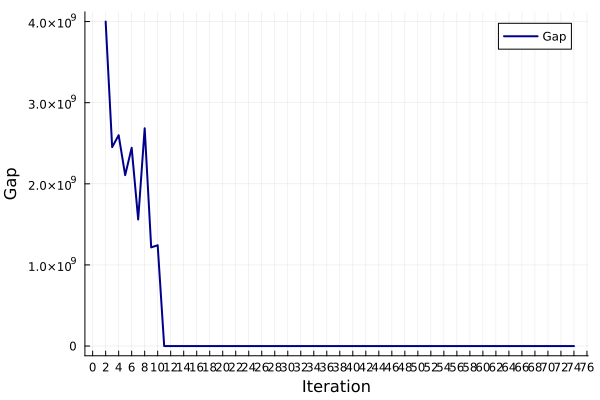

In [8]:
#plotly()
plot_gap(df_LR_interations)

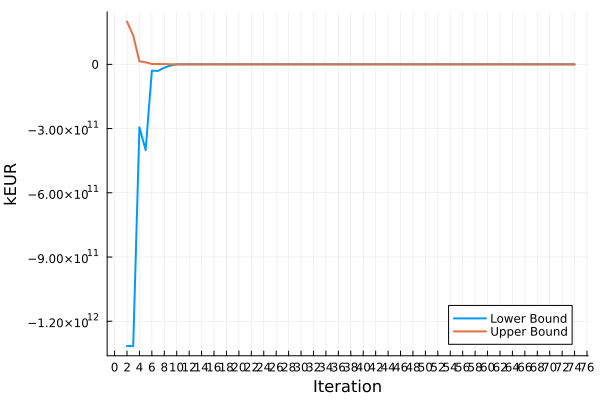

In [9]:
plot_bounds(df_LR_interations)

Optimal solution of the LR (linear combination of all iterations)

**Note:** This solution is infeasible in the complete problem

In [10]:
show(df_results_per_iteration)

876×4 DataFrame
 Row │ iteration  scenario  generator  investment 
     │ Int64      String    String     Float64    
─────┼────────────────────────────────────────────
   1 │         1  sc1       ocgt              0.0
   2 │         1  sc1       ccgt              3.0
   3 │         1  sc1       wind              0.0
   4 │         1  sc1       solar           144.0
   5 │         1  sc2       ocgt              2.0
   6 │         1  sc2       ccgt              0.0
   7 │         1  sc2       wind             51.0
   8 │         1  sc2       solar             0.0
  ⋮  │     ⋮         ⋮          ⋮          ⋮
 870 │        73  sc2       ccgt              2.0
 871 │        73  sc2       wind             35.0
 872 │        73  sc2       solar            45.0
 873 │        73  sc3       ocgt             12.0
 874 │        73  sc3       ccgt              0.0
 875 │        73  sc3       wind            186.0
 876 │        73  sc3       solar           192.0
                                  86

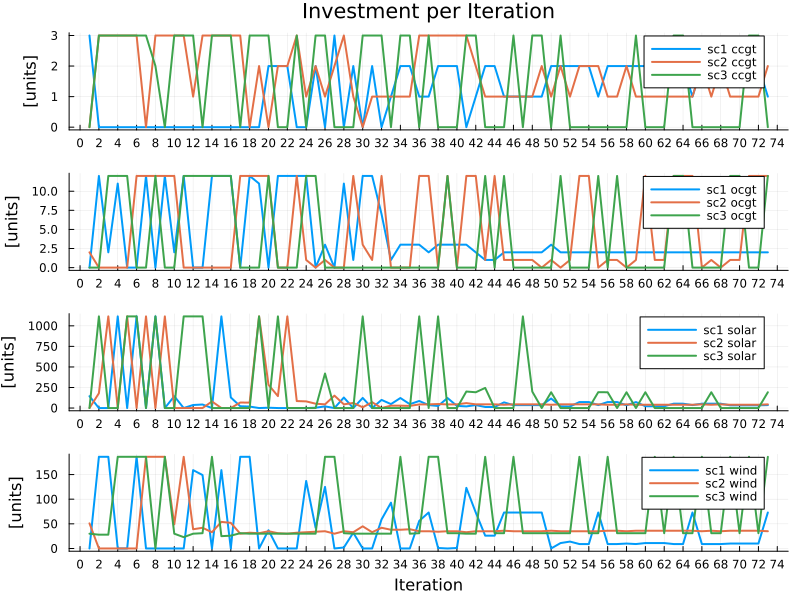

In [12]:
plot_investment_per_iteration_LR(df_results_per_iteration)

In [13]:
# Create a DataFrame with the results for LR cuts duals for each iteration
df_LR_cuts_dual = DataFrame(;
    iteration=1:(last_iteration-1),
    cuts_dual=[
        -dual(first_stage_model[Symbol("cut_iter_$(iteration)")]) for
        iteration in 1:(last_iteration-1)
    ],
)
show(df_LR_cuts_dual)

73×2 DataFrame
 Row │ iteration  cuts_dual  
     │ Int64      Float64    
─────┼───────────────────────
   1 │         1  -0.0
   2 │         2  -0.0
   3 │         3  -0.0
   4 │         4  -0.0
   5 │         5  -0.0
   6 │         6  -0.0
   7 │         7  -0.0
   8 │         8  -0.0
  ⋮  │     ⋮          ⋮
  67 │        67   0.188912
  68 │        68   0.15714
  69 │        69   0.0284533
  70 │        70   0.0483686
  71 │        71  -0.0
  72 │        72   0.0422454
  73 │        73  -0.0
              58 rows omitted

In [14]:
# join the results with the cuts duals into df_results_per_iteration
df_results_per_iteration = leftjoin(df_results_per_iteration, df_LR_cuts_dual, on=:iteration)
show(df_results_per_iteration)

876×5 DataFrame
 Row │ iteration  scenario  generator  investment  cuts_dual 
     │ Int64      String    String     Float64     Float64?  
─────┼───────────────────────────────────────────────────────
   1 │         1  sc1       ocgt              0.0       -0.0
   2 │         1  sc1       ccgt              3.0       -0.0
   3 │         1  sc1       wind              0.0       -0.0
   4 │         1  sc1       solar           144.0       -0.0
   5 │         1  sc2       ocgt              2.0       -0.0
   6 │         1  sc2       ccgt              0.0       -0.0
   7 │         1  sc2       wind             51.0       -0.0
   8 │         1  sc2       solar             0.0       -0.0
  ⋮  │     ⋮         ⋮          ⋮          ⋮           ⋮
 870 │        73  sc2       ccgt              2.0       -0.0
 871 │        73  sc2       wind             35.0       -0.0
 872 │        73  sc2       solar            45.0       -0.0
 873 │        73  sc3       ocgt             12.0       -0.0
 874 │   

In [15]:
# get a new column with the multiplication of the investment and the cut dual
df_results_per_iteration[!, :investment_cut_dual] =
    df_results_per_iteration[!, :investment] .* (df_results_per_iteration[!, :cuts_dual])

# group by scenario and generator and sum the investment_cut_dual
df_results_per_iteration_grouped =
    combine(groupby(df_results_per_iteration, [:scenario, :generator]), :investment_cut_dual => sum)
show(df_results_per_iteration_grouped)


12×3 DataFrame
 Row │ scenario  generator  investment_cut_dual_sum 
     │ String    String     Float64                 
─────┼──────────────────────────────────────────────
   1 │ sc1       ocgt                       2.0
   2 │ sc1       ccgt                       1.58974
   3 │ sc1       wind                      35.4103
   4 │ sc1       solar                     42.9487
   5 │ sc2       ocgt                       2.0
   6 │ sc2       ccgt                       1.58974
   7 │ sc2       wind                      35.4103
   8 │ sc2       solar                     42.9487
   9 │ sc3       ocgt                       2.0
  10 │ sc3       ccgt                       1.58974
  11 │ sc3       wind                      35.4103
  12 │ sc3       solar                     42.9487

In [16]:
write_to_file(first_stage_model, "first_stage_model.lp")